# Introduction

Two-sample Mendelian Randomization (MR) is a powerful statistical method used to infer causal relationships between risk factors and health outcomes using genetic data. In this approach, genetic variants associated with an exposure (such as cholesterol levels) are used as instruments to assess their effect on an outcome (like heart disease) in separate, independent samples. By leveraging genetic variants, which are randomly allocated and less influenced by confounding factors, two-sample MR provides a robust way to estimate causal effects and avoid some of the biases present in traditional observational studies.

This method involves obtaining summary statistics from two distinct datasets: one for the exposure and one for the outcome. By combining these datasets, researchers can estimate the causal effect of the exposure on the outcome with increased statistical power and precision. Two-sample MR is widely used in public health and biostatistics to provide insights into how modifiable risk factors impact health outcomes, guiding more effective prevention and treatment strategies.

In this notebook you will perform a two-sample Mendelian Randomization study. We will apply MR-IVW (Inverse-Variance Weighted) and MR-Egger on a toy dataset to estimate causal effects. MR-IVW combines multiple genetic instruments by weighting them according to their precision, assuming all instruments are valid. In contrast, MR-Egger Regression allows for potential pleiotropy (where instruments affect the outcome through pathways other than the exposure) by including an intercept term to adjust for directional pleiotropy, providing a more flexible approach when there are concerns about instrument validity. At the end there is a bonus question to run five main MR methods all together on the simulated data and analyze the results. 

# Load and preprocess the data

First please load the data in `../data/MR_genotype_data_with_missing.csv` and `../data/MR_phenotype_data_with_missing.csv` and name them `genotype_data` and `phenotype_data`. Keep the names same before and after the imputation.

***

**Question 1: analyze the pattern of missing data in the phenotype dataset. Are there any specific patterns (e.g., missingness concentrated in certain columns or rows)?**

**Answer:**

By examining the pattern of the missing data in `phenotype_data` data frame, the missing data mainly appears in the `outcome` and `exposure` columns, with 20 and 30 data missing respectively. No data is missing in other three columns. Each row has at most 1 feature missing. 95% of the rows do not have missing value.

In [33]:
# Load the data

# setwd("../")
setwd("/Users/xujingyi/Documents/Columbia/Leal lab/student_test_2024_fall")
# getwd()

genotype_data <- read.csv("data/MR_genotype_data_with_missing.csv")
phenotype_data <- read.csv("data/MR_phenotype_data_with_missing.csv")
dim(genotype_data)
dim(phenotype_data)

[1] 1000   51

[1] 1000    5

In [ ]:
# Install the package
install.packages("mice")
install.packages("dyplr")

In [ ]:
# Load the package
library(mice)

,Individual_ID,Age,Sex,Outcome,Exposure,
950,1,1,1,1,1,0
30,1,1,1,1,0,1
20,1,1,1,0,1,1
,0,0,0,20,30,50


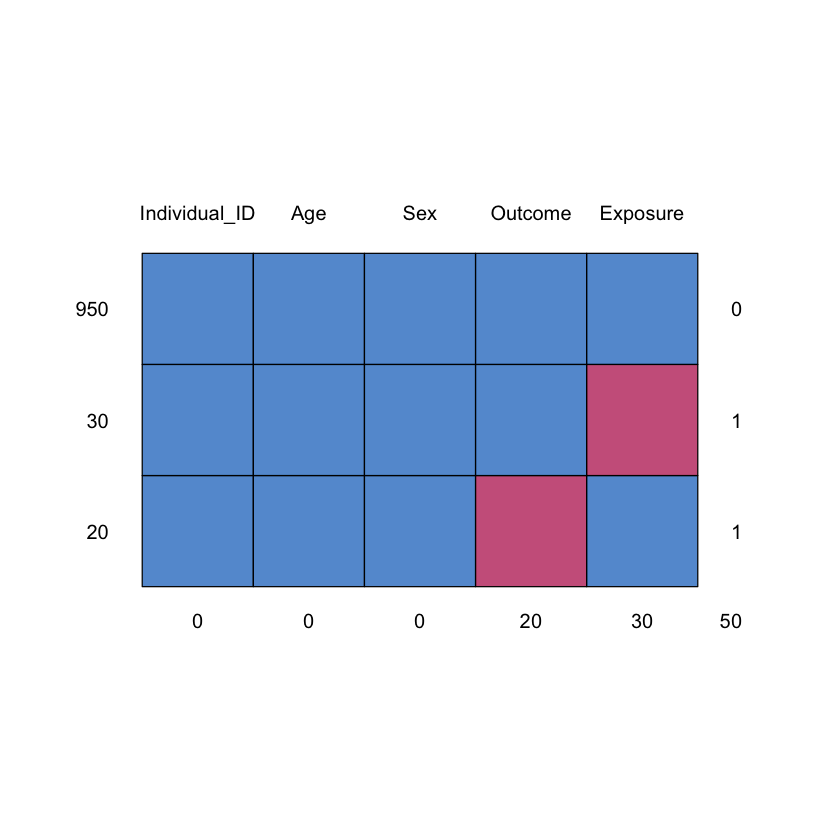

In [28]:
# Examine the missing data
colSums(is.na(phenotype_data))
rowSums(is.na(phenotype_data))

md.pattern(phenotype_data)

***

**Question 2: given the missingness of data, please perform mode imputation for the genotype data and mean imputation for the phenotype data. Report what is the average age after imputation?**

**Answer:**

The missing data was imputed by mode imputation and mean imputation for `genotype_data` and `phenotype_data` respectively. The average age for the `phenotype_data` after imputation is 49.6543254337334.

In [ ]:
# Load the packages
library(dplyr)
library(mice)

In [ ]:
# Mode imputation for genotype data

mode_impute <- function(x) {
  ux <- unique(x[!is.na(x)])
  ux[which.max(tabulate(match(x, ux)))]
}

md.pattern(genotype_data)
genotype_data <- genotype_data |>
  mutate(across(everything(), ~ ifelse(is.na(.), mode_impute(.), .)))
md.pattern(genotype_data)

In [ ]:
# Mean imputation for phenotype data
phenotype_data <- phenotype_data |>
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .)))
md.pattern(phenotype_data)

In [37]:
# Calculate the average of the phenotype data
average_age <- mean(phenotype_data$Age, na.rm = TRUE)
average_age

[1] 49.65433

***

# Instrument selection

Now we can use the genotype data to calculate SNP-exposure associations (i.e., estimate the beta values for SNPs). Basically you can do a linear regression between the exposure and each variant and collect the coefficients:

In [ ]:
snp_exposure_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                    Beta = numeric(ncol(genotype_data) - 1),
                                    SE = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {
  genotype <- genotype_data[[snp]]
  exposure <- phenotype_data$Exposure
  fit <- lm(exposure ~ genotype)
  snp_exposure_results$Beta[snp_exposure_results$SNP == snp] <- coef(fit)[2]
  snp_exposure_results$SE[snp_exposure_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
}

***

**Question 3: please only select the variants with p-value smaller than 0.01. How many are there?**

**Answer:**

There are 17 variants with p-value smaller than 0.01.

In [41]:
# Calculate the p-values
snp_exposure_results$p_value <- 2 * (1 - pnorm(abs(snp_exposure_results$Beta / snp_exposure_results$SE)))
head(snp_exposure_results)

# Select the significant SNPs
significant_snps <- snp_exposure_results[snp_exposure_results$p_value < 0.01, ]

number_of_significant_snps <- nrow(significant_snps)

number_of_significant_snps

,SNP,Beta,SE,p_value
,<chr>,<dbl>,<dbl>,<dbl>
1,rs1,0.04006549,0.05412598,0.4591625674
2,rs2,0.09201819,0.05383759,0.0874173815
3,rs3,0.17546103,0.05278291,0.0008867202
4,rs4,0.15615708,0.05205576,0.0027015316
5,rs5,0.11350794,0.05472240,0.0380560792
6,rs6,0.13837298,0.05353437,0.0097449566


[1] 17

***

# SNP-outcome association

***

**Question 4: please run the association analysis between variants and the outcome.**

**Answer:**

In [42]:
snp_outcome_results <- data.frame(SNP = colnames(genotype_data)[-1],
                                  Beta = numeric(ncol(genotype_data) - 1),
                                  SE = numeric(ncol(genotype_data) - 1),
                                  p_value = numeric(ncol(genotype_data) - 1))

for (snp in colnames(genotype_data)[-1]) {

  genotype <- genotype_data[[snp]]
  outcome <- phenotype_data$Outcome

  fit <- lm(outcome ~ genotype)
  
  snp_outcome_results$Beta[snp_outcome_results$SNP == snp] <- coef(fit)[2]
  snp_outcome_results$SE[snp_outcome_results$SNP == snp] <- summary(fit)$coefficients[2, 2]
  
  t_value <- coef(fit)[2] / summary(fit)$coefficients[2, 2]
  snp_outcome_results$p_value[snp_outcome_results$SNP == snp] <- 2 * (1 - pnorm(abs(t_value)))
}

# 查看结果
head(snp_outcome_results)

,SNP,Beta,SE,p_value
,<chr>,<dbl>,<dbl>,<dbl>
1,rs1,-0.05044823,0.05605534,3.681352e-01
2,rs2,0.42950695,0.05416528,2.220446e-15
3,rs3,0.19954450,0.05460931,2.581480e-04
4,rs4,0.16212542,0.05391724,2.638997e-03
5,rs5,0.07751324,0.05674947,1.719751e-01
6,rs6,0.12180204,0.05550144,2.819415e-02


***

# Run two-sample MR

Noe we are ready to run the two-sample MR analysis. Here we can use a R package called [`MendelianRandomization` on CRAN](https://cran.r-project.org/web/packages/MendelianRandomization/index.html).

In [43]:
# Install MendelianRandomization package if not already installed
if (!requireNamespace("MendelianRandomization", quietly = TRUE)) {
  install.packages("MendelianRandomization")
}

# Load the package
library(MendelianRandomization)

also installing the dependencies 'gmp', 'arrangements', 'iterpc', 'rjson'





The downloaded binary packages are in
	/var/folders/f9/1k8_8ryd75b1wll9n2_t2jqc0000gn/T//RtmpFAN5we/downloaded_packages


In the vignette [here](https://cran.r-project.org/web/packages/MendelianRandomization/vignettes/Vignette_MR.pdf), please learn how to apply two basic MR methods -- MR-IVW amd MR-Egger. 

**Hint: the input for `mr_ivw` function consists of four components: coefficients and standard errors between variants and exposures, and between variants and outcome. Same for `mr_egger`. Check page 4 and 6 on the vignette PDF.**

***

**Question 5: please run the MR-IVW and MR-Egger analysis.**

**Answer:**

In [ ]:
# Generate object for MR analysis
MRInputObject <- mr_input(bx = snp_exposure_results$Beta,
                        bxse = snp_exposure_results$SE,
                        by = snp_outcome_results$Beta,
                        byse = snp_outcome_results$SE)

In [46]:
# ME-IVW analysis
IVWObject <- mr_ivw(MRInputObject,
                    model = "default",
                    robust = FALSE,
                    penalized = FALSE,
                    correl = FALSE,
                    weights = "simple",
                    psi = 0,
                    distribution = "normal",
                    alpha = 0.05)

IVWObject


Inverse-variance weighted method
(variants uncorrelated, random-effect model)

Number of Variants : 50 

------------------------------------------------------------------
 Method Estimate Std Error 95% CI       p-value
    IVW    1.112     0.153 0.812, 1.413   0.000
------------------------------------------------------------------
Residual standard error =  2.309 
Heterogeneity test statistic (Cochran's Q) = 261.1731 on 49 degrees of freedom, (p-value = 0.0000). I^2 = 81.2%. 
F statistic = 4.9. 

In [47]:
EggerObject <- mr_egger(MRInputObject,
                        robust = FALSE,
                        penalized = FALSE,
                        correl = FALSE,
                        distribution = "normal",
                        alpha = 0.05)
EggerObject


MR-Egger method
(variants uncorrelated, random-effect model)

Number of Variants =  50 

------------------------------------------------------------------
      Method Estimate Std Error  95% CI       p-value
    MR-Egger    0.754     0.337  0.094, 1.415   0.025
 (intercept)    0.047     0.040 -0.030, 0.125   0.234
------------------------------------------------------------------
Residual Standard Error :  2.299 
Heterogeneity test statistic = 253.6721 on 48 degrees of freedom, (p-value = 0.0000)
I^2_GX statistic: 1.1%

***

# Analyze the results

***

**Question 6: Using the MR-IVW and MR-Egger methods, report the estimated causal effect of the exposure on the outcome, along with standard errors, 95% confidence intervals, and p-values. Compare the estimates from MR-IVW and MR-Egger. What are the key differences between the two methods in your results?**

**Answer:**

**Summary of MR-IVW and MR-Egger Results**
| Methods | Estimated Causal Effect | Standard Error | 95% Confidence Interval | p-value |
|---------|-------------------------|----------------|-------------------------|---------|
| MR-IVW  | 1.112                   | 0.153          | (0.812, 1.413)          | 0.000   |
| MR-Egger| 0.754                   | 0.337          | (0.094, 1.415)          | 0.025   | 

MR-IVW gives a higher estimate (1.112) compared to MR-Egger (0.754). This is expected because MR-Egger adjusts for potential pleiotropy, which often leads to more conservative (lower) estimates. However, given that the p-value for the intercept of MR-Egger method is less than 0.05, suggesting a not significant intercept. Pleiotropy might not be a major issue in this analysis. However, the MR-Egger approach still provides a more conservative causal estimate in case pleiotropy is present.

**Key differences:** MR-IVW assumes that all genetic instruments are valid, while MR-Egger accounts for pleiotropy. This results in MR-Egger being more conservative but also more flexible in handling invalid instruments. 

***

**Question 7 (optional): Run all the primary Mendelian Randomization methods using the `mr_allmethods` function from the package (use the code below). Visualize the results with the `mr_plot` function. Based on your findings, provide an analysis of the results and discuss the reasons for any observed patterns or outcomes.**

```R
res = mr_allmethods(mr_input(bx=merged_results$Beta_exposure, bxse=merged_results$SE_exposure, 
                               by=merged_results$Beta_outcome, byse=merged_results$SE_outcome), method = "main")
```


          Method Estimate Std Error 95% CI        P-value
   Simple median    0.877     0.130   0.622 1.133   0.000
 Weighted median    0.869     0.124   0.627 1.112   0.000
             IVW    1.112     0.153   0.812 1.413   0.000
        MR-Egger    0.754     0.337   0.094 1.415   0.025
     (intercept)    0.047     0.040  -0.030 0.125   0.234

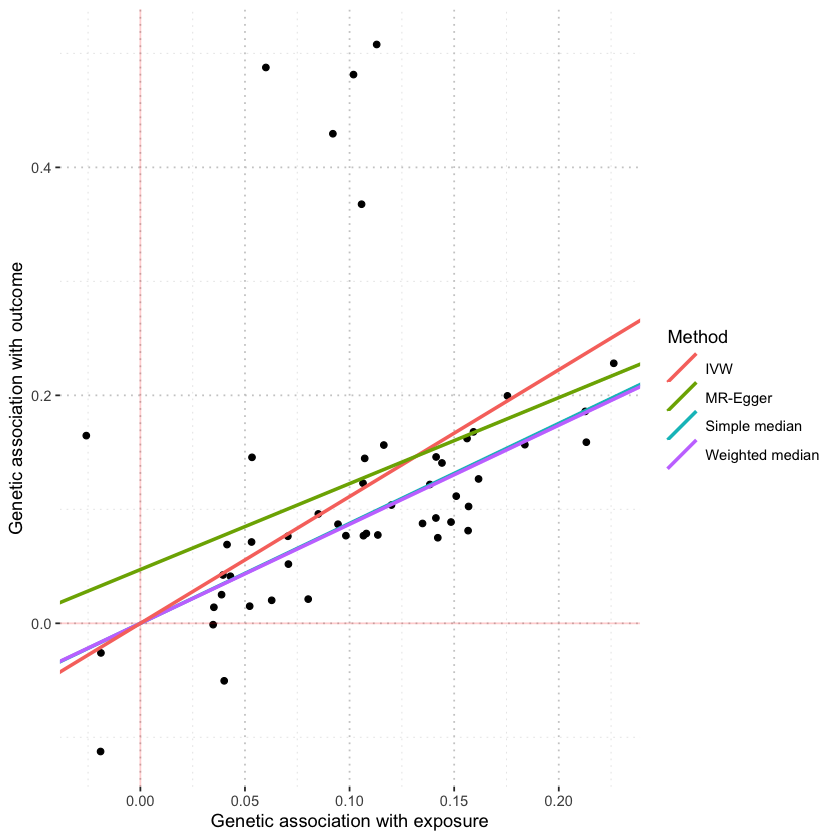

In [51]:
res = mr_allmethods(MRInputObject, method = "main")

res

# Visualize the results
mr_plot(res)

**IVW (Inverse-Variance Weighted) Method:**
The IVW estimate is the highest at 1.112, with a narrow confidence interval, suggesting a relatively precise estimate. This method assumes no pleiotropy and typically has greater statistical power. However, if there is directional pleiotropy, the IVW method may produce a biased estimate.
MR-Egger Method:

**MR-Egger Method:**
The MR-Egger estimate is lower (0.754) and has a wider confidence interval, indicating less precision. The wider interval suggests uncertainty in the estimate, likely because MR-Egger adjusts for potential pleiotropy, resulting in a more conservative estimate.
Median-based Methods (Simple and Weighted Median):

**Median-based Methods (Simple and Weighted Median):**
Both the simple median and weighted median methods provide estimates that lie between MR-Egger and IVW, around 0.87. These methods are less sensitive to invalid instruments, making them robust against certain types of pleiotropy.
The weighted median has a narrower confidence interval compared to the simple median, indicating greater precision.

**Discussion of patterns:**
The IVW method suggests the strongest causal effect, while MR-Egger provides a more conservative estimate, indicating possible pleiotropy. The median-based methods offer estimates in between, suggesting that the causal effect is likely present but could be slightly inflated by invalid instruments.